##掛載雲端硬碟


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##更改檔案所在路徑

In [2]:
# Change to your own folder !!!
%cd /content/drive/MyDrive/EAI_Lab4_2024

/content/drive/MyDrive/EAI_Lab4_2024


## Import library

In [3]:
from __future__ import print_function
import os
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from models import vgg

## 設定超參數

In [4]:
TRAIN_BATCH_SIZE = 100
TEST_BATCH_SIZE = 1000
EPOCHS = 20
LEARNING_RATE = 0.1
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
LOG_INTERVAL = 100
CUDA = True
SEED = 1

RESUME = True
START_EPOCH = 0

PRUNE_PATH = '/content/drive/MyDrive/Colab Notebooks/model_prune.pth'
PRUNE_FINETUNE_PATH = '/content/drive/MyDrive/Colab Notebooks/model_prune_finetune.pth'


####檢查是否檢查是否可使用GPU

In [5]:
if(torch.cuda.is_available()):
    CUDA = True
    kwargs = {'num_workers': 1, 'pin_memory': True}
    torch.cuda.manual_seed(SEED)
else:
    CUDA = False
    kwargs = {}


##下載資料集


這裡將訓練集做Augmentation(Pad, RandCrop, Random)，測試集不用做Augmentation

In [6]:
#### DATASET ####
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Pad(4),
                       transforms.RandomCrop(32),
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=TRAIN_BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=TEST_BATCH_SIZE, shuffle=True, **kwargs)

Files already downloaded and verified


## 載入剪枝後的網路與權重

In [8]:
model = None
if(RESUME):
  checkpoint = torch.load(PRUNE_PATH)
  model = vgg(cfg=checkpoint['cfg'])
  model.load_state_dict(checkpoint['state_dict'])

  print('RESUME PRUNE MODEL')

if CUDA:
    model.cuda()

RESUME PRUNE MODEL


<ipython-input-8-f78e2976aa2b>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(PRUNE_PATH)


##設定Optimizer，這裡使用Stocastic Gradient Descent with

In [9]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

## 定義訓練跟測試函數

In [10]:
# 新增變數來記錄每個 epoch 的訓練和測試精度
train_accuracies = []
test_accuracies = []

#### 訓練函數 #####
def train(epoch):
    model.train()
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        if CUDA:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        # 計算正確的預測數量
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
        total += target.size(0)

        if batch_idx % LOG_INTERVAL == 0:
            print('\nTrain Epoch: {} [{}/{} ({:.1f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

    # 計算當前 epoch 的訓練精度並記錄
    train_accuracy = correct / total
    train_accuracies.append(train_accuracy)
    print(f'Epoch {epoch}, Train Accuracy: {train_accuracy:.4f}')

#### 測試函數 ####
def test():
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            if CUDA:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').data.item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / float(len(test_loader.dataset))
    test_accuracies.append(test_accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * test_accuracy))
    return test_accuracy

best_prec1 = 0.
for epoch in range(START_EPOCH, EPOCHS):
    # 動態調整學習率
    if epoch in [int(EPOCHS*0.5), int(EPOCHS*0.75)]:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1

    train(epoch)
    prec1 = test()

    # 儲存模型權重，方便做後續剪枝和微調
    if prec1 > best_prec1:
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
            'optimizer': optimizer.state_dict(),
        }, PRUNE_FINETUNE_PATH)

    best_prec1 = max(prec1, best_prec1)

print('\n TRAIN PRUNED MODEL DONE!')



Train Epoch: 0 [0/50000 (0.0%)]	Loss: 0.263627

Train Epoch: 0 [10000/50000 (20.0%)]	Loss: 0.636670

Train Epoch: 0 [20000/50000 (40.0%)]	Loss: 0.369313

Train Epoch: 0 [30000/50000 (60.0%)]	Loss: 0.529915

Train Epoch: 0 [40000/50000 (80.0%)]	Loss: 0.384669
Epoch 0, Train Accuracy: 0.8164

Test set: Average loss: 0.5948, Accuracy: 8106/10000 (81.1%)


Train Epoch: 1 [0/50000 (0.0%)]	Loss: 0.452769

Train Epoch: 1 [10000/50000 (20.0%)]	Loss: 0.410034

Train Epoch: 1 [20000/50000 (40.0%)]	Loss: 0.380960

Train Epoch: 1 [30000/50000 (60.0%)]	Loss: 0.420684

Train Epoch: 1 [40000/50000 (80.0%)]	Loss: 0.464060
Epoch 1, Train Accuracy: 0.8485

Test set: Average loss: 0.6045, Accuracy: 8017/10000 (80.2%)


Train Epoch: 2 [0/50000 (0.0%)]	Loss: 0.395285

Train Epoch: 2 [10000/50000 (20.0%)]	Loss: 0.361355

Train Epoch: 2 [20000/50000 (40.0%)]	Loss: 0.512073

Train Epoch: 2 [30000/50000 (60.0%)]	Loss: 0.391972

Train Epoch: 2 [40000/50000 (80.0%)]	Loss: 0.432530
Epoch 2, Train Accuracy: 0.855

## 繪製Fine-tuning結果圖


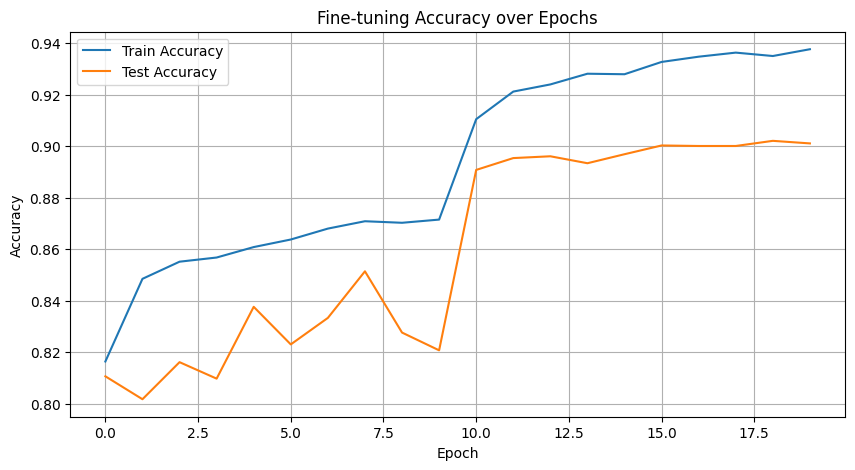

In [11]:
# 繪製 Fine-tuning 結果圖
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(START_EPOCH, EPOCHS), train_accuracies, label='Train Accuracy')
plt.plot(range(START_EPOCH, EPOCHS), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Fine-tuning Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()
